# ECE324 Mini-Project 1

Amy Chen, 1005915495

## Initial Setup

The initial setup contains the library imports and functions for data preprocessing. As mentioned in the function descriptions, the 7 selected features that were used for parts 1 and 2 are: Age, Sex, Juvenile misdemeanor count, Juvenile felonies count, Priors count, Charge degree, and Charge description. One-hot encoding was applied to the following features: Sex, Charge degree, and Charge description.

In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
# Functions for data preprocessing that are used in both part 1 and part 2

def encode_and_bind(og_df, feature_to_encode):
    """
    Performs one-hot encoding and concatenates the encoded columns into the dataframe
    """
    encoding = pd.get_dummies(og_df[[feature_to_encode]])
    new_df = pd.concat([og_df, encoding], axis=1)
    new_df = new_df.drop([feature_to_encode], axis=1)
    return new_df

def selected_features(og_df):
    """
    Selects the features and performs one-hot encoding on certain features
    The 7 selected features are:
      - Age
      - Sex
      - Juvenile misdemeanor count
      - Juvenile felonies count
      - Priors count
      - Charge degree
      - Charge description
    One-hot encoding is applied to the following features:
      - Sex
      - Charge degree
      - Charge description
    The race and two-year-recividism are kept in the dataset for now but will be removed later
    """
    new_df = og_df[['age', 'sex', 'juv_misd_count', 'juv_fel_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'race', 'two_year_recid']]
    new_df = encode_and_bind(new_df, 'sex')
    new_df = encode_and_bind(new_df, 'c_charge_degree')
    new_df = encode_and_bind(new_df, 'c_charge_desc')
    return new_df

def drop_selected_features(og_df):
    """
    Drops the race and two-year recividism columns that are not used as model inputs
    """
    new_df = og_df.drop(['race'], axis=1)
    new_df = new_df.drop(['two_year_recid'], axis=1)
    return new_df

def drop_rows(og_df):
    """
    Drops the rows for all other races other than Caucasian and African-American
    """
    new_df = og_df.drop(og_df[og_df.race == 'Hispanic'].index)
    new_df = new_df.drop(new_df[new_df.race == 'Other'].index)
    new_df = new_df.drop(new_df[new_df.race == 'Native American'].index)
    new_df = new_df.drop(new_df[new_df.race == 'Asian'].index)
    return new_df

## Part 1

The following class defines the Logistic Regresssion model.

In [ ]:
class LogisticRegression(torch.nn.Module):
     
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     
     def forward(self, x):
         y_pred = torch.sigmoid(self.linear(x))
         return y_pred

Data preprocessing was done using the functions that were defined earlier. Only the seven features that was mentioned by the paper by Dressel et al. were used and one-hot encoding was performed on the non-numerical features. As well, the inputs were all converted into torch tensors so that they were in the correct format that was needed for the model. The testing data was also separated into two groups based on race (Caucasian and African-American) in order to determine if FPR parity and calibration are satisfied.

In [ ]:
# Read in data as a dataframe
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')

# Get selected features from dataset and split into training and test set
df = selected_features(df)
data_train, data_test = train_test_split(df, test_size=0.20, random_state=25)

# Print base rates from dataset
c = df.loc[df['race'] == 'Caucasian']
aa = df.loc[df['race'] == 'African-American']
c_recidivate = c.loc[c['two_year_recid'] == 1]
aa_recidivate = aa.loc[aa['two_year_recid'] == 1]
print("==== Base Rates ====")
print("\nCaucasians:")
print("Total number: %d" %(len(c)))
print("Number that recidivated: %d" %(len(c_recidivate)))
print("Recidivism Rate: %.4f%%" %(100.0*len(c_recidivate)/len(c)))
print("\nAfrican-Americans:")
print("Total number: %d" %(len(aa)))
print("Number that recidivated: %d" %(len(aa_recidivate)))
print("Recidivism Rate: %.4f%%" %(100.0*len(aa_recidivate)/len(aa)))

==== Base Rates ====

Caucasians:
Total number: 2454
Number that recidivated: 966
Recidivism Rate: 39.3643%

African-Americans:
Total number: 3696
Number that recidivated: 1901
Recidivism Rate: 51.4340%


In [ ]:
# ==== Training Data ====
x_train = drop_selected_features(data_train) # Training input data
y_train = data_train['two_year_recid'] # Training labels

x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) # Training input data tensor
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)) # Training labels tensor

# ==== Testing Data with features ====

# Testing inputs and labels for Caucasian race
x_test_c = data_test.loc[data_test['race'] == 'Caucasian']
y_test_c = x_test_c['two_year_recid']
x_test_c = drop_selected_features(x_test_c)

# Testing inputs and labels for African-American race
x_test_aa = data_test.loc[data_test['race'] == 'African-American']
y_test_aa = x_test_aa['two_year_recid']
x_test_aa = drop_selected_features(x_test_aa)

# Testing tensors
x_test_c_tensor = torch.tensor(x_test_c.values.astype(np.float32))
y_test_c_tensor = torch.tensor(y_test_c.values.astype(np.float32))
x_test_aa_tensor = torch.tensor(x_test_aa.values.astype(np.float32))
y_test_aa_tensor = torch.tensor(y_test_aa.values.astype(np.float32))

The following defines the logistic regression model with binary cross-entropy loss and the SGD optimizer with a learning rate of 0.001.

In [ ]:
# Hyperparameters
input_dim = len(x_train.columns)
output_dim = 1
learningRate = 0.001
numEpochs = 200

# Model, loss, and optimizer initializations
model = LogisticRegression(input_dim,output_dim) # Initialize logistic regression model
lossFunc = torch.nn.BCELoss() # Binary Cross-Entropy Loss
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate) # Initialize SGD optimizer

The model was trained for a total of 200 epochs and the training loss and accuracy is plotted below.

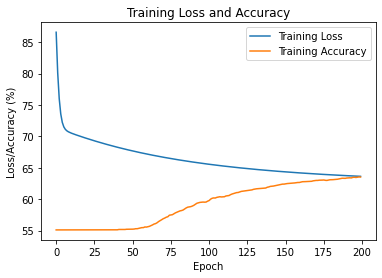

In [ ]:
# ==== Model Training ====

# Variables to keep track of loss and accuracy
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(numEpochs):
    optimizer.zero_grad()

    # Model predictions
    y_train_pred = torch.squeeze(model(x_train_tensor))

    # Get loss
    train_loss = lossFunc(y_train_pred, y_train_tensor)

    train_loss.backward()
    optimizer.step()

    # Append loss and accuracy to arrays
    train_losses.append(100.0*train_loss.detach().numpy())
    train_acc = 100.0*(np.sum(y_train_pred.round().detach().numpy() == y_train_tensor.detach().numpy())/len(y_train_tensor))
    train_accuracies.append(train_acc)

    #print('=== Epoch %04d  Training Loss %.4f Training Accuracy %.4f Testing Loss %.4f Testing Accuracy %.4f ===' % (epoch + 1, train_loss, train_acc, test_loss, test_acc))

# Plot Loss and Accuracy
plt.title("Training Loss and Accuracy")
plt.plot(train_losses, label="Training Loss")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy (%)")
plt.legend(loc='best')
plt.show()

### Part 1a) Model Satisfies Calibration but Not FPR Parity

From the test results, we can calculate the FPR, PPV, and NPV of both the racial groups using the following formulas:

> FPR (%) = 100 * FP / (FP + TN)
>
> PPV (%) = 100 * TP / (TP + FP)
>
> NPV (%) = 100 * FN / (TN + FN)
>
> where TP = True Positives, TN = True Negatives, FP = False Positives, FN = False Negatives

To see if FPR parity is satisfied (ie. there is equal FPR across race groups), we calculate the FPR for the two racial groups and see if the difference is less than 5%. To see if calibration is satisfied (ie. the proportion that would reoffend if released is equal across race groups), we check for PPV and NPV parity such that there is a less than 5% difference in both the PPV and NPV for the two racial groups.

From the results we can see that for the model we were unable to satisfy FPR parity but satisfied both PPV and NPV parity and so therefore satisfied calibration.

The difference in base rates in the dataset show that there is a higher recidivism rate for African Americans which may bias the model to have a higher tendency to classify those as African American as recidivating. Therefore, this would lead to a higher FPR for African American's and a lower FPR for Caucasian's, resulting in a higher FPR difference between the two racial groups such that FPR parity is not satisfied.

In [ ]:
# ==== Test Results ====

# Get predictions
y_test_pred_c = torch.squeeze(model(x_test_c_tensor)).round().detach().numpy()
y_test_pred_aa = torch.squeeze(model(x_test_aa_tensor)).round().detach().numpy()

# Results for African American Race
aa_cm = confusion_matrix(y_test_aa_tensor.detach().numpy(), y_test_pred_aa)
aa_tn, aa_fp, aa_fn, aa_tp = aa_cm.ravel()
aa_fpr = 100.0*aa_fp/(aa_fp+aa_tn)
aa_ppv = 100.0*aa_tp/(aa_tp+aa_fp)
aa_npv = 100.0*aa_fn/(aa_tn+aa_fn)
print("====== Test Results for Race: African American ======")
print("TN: %d, FP: %d, FN: %d, TP: %d" %(aa_tn, aa_fp, aa_fn, aa_tp))
print("Recidivism Number: %d, Total Number: %d, Recidivism Rate: %.4f" %(np.sum(y_test_aa_tensor.detach().numpy()), 
                                                  len(y_test_aa_tensor), 
                                                  np.sum(y_test_aa_tensor.detach().numpy())/len(y_test_aa_tensor)))
print("False Positive Rate (FPR): %.4f%%" %(aa_fpr))
print("Positive Predictive Value (PPV): %.4f%%" %(aa_ppv))
print("Negative Predictive Value (NPV): %.4f%%" %(aa_npv))
print("\n")

# Results for Caucasian Race
c_cm = confusion_matrix(y_test_c_tensor.detach().numpy(), y_test_pred_c)
c_tn, c_fp, c_fn, c_tp = c_cm.ravel()
c_fpr = 100.0*c_fp/(c_fp+c_tn)
c_ppv = 100.0*c_tp/(c_tp+c_fp)
c_npv = 100.0*c_fn/(c_tn+c_fn)
print("====== Test Results for Race: Caucasian ======")
print("TN: %d, FP: %d, FN: %d, TP: %d" %(c_tn, c_fp, c_fn, c_tp))
print("Recidivism Number: %d, Total Number: %d, Recidivism Rate: %.4f" %(np.sum(y_test_c_tensor.detach().numpy()), 
                                                  len(y_test_c_tensor), 
                                                  np.sum(y_test_c_tensor.detach().numpy())/len(y_test_c_tensor)))
print("False Positive Rate (FPR): %.4f%%" %(c_fpr))
print("Positive Predictive Value (PPV): %.4f%%" %(c_ppv))
print("Negative Predictive Value (NPV): %.4f%%" %(c_npv))
print("\n")

# Test Results
print("====== Test Results ======")
print("Testing Accuracy: %.4f%%" %(100.0*(aa_tn + aa_tp + c_tn + c_tp)/(aa_tn + aa_fp + aa_fn + aa_tp + c_tn + c_fp + c_fn + c_tp)))
print("Difference in FPR between races: %.4f%%" %(abs(aa_fpr - c_fpr)))
print("Difference in PPV between races: %.4f%%" %(abs(aa_ppv - c_ppv)))
print("Difference in NPV between races: %.4f%%" %(abs(aa_npv - c_npv)))

====== Test Results for Race: African American ======
TN: 318, FP: 53, FN: 240, TP: 140
Recidivism Number: 380, Total Number: 751, Recidivism Rate: 0.5060
False Positive Rate (FPR): 14.2857%
Positive Predictive Value (PPV): 72.5389%
Negative Predictive Value (NPV): 43.0108%


====== Test Results for Race: Caucasian ======
TN: 260, FP: 13, FN: 169, TP: 37
Recidivism Number: 206, Total Number: 479, Recidivism Rate: 0.4301
False Positive Rate (FPR): 4.7619%
Positive Predictive Value (PPV): 74.0000%
Negative Predictive Value (NPV): 39.3939%


====== Test Results ======
Testing Accuracy: 61.3821%
Difference in FPR between races: 9.5238%
Difference in PPV between races: 1.4611%
Difference in NPV between races: 3.6168%


### Part 1b) Threshold Adjustment Satisifes FPR parity but not calibration

The same calculations as above were used to determine if FPR parity and calibration are satisfied.

The threshold was adjusted with the threshold for African-Americans being 0.7 and the threshold for Caucasians being 0.6. From the results below it can be seen that adjusting the thresholds led to FPR parity being satisfied but calibration was not satisfied.

In [ ]:
# ==== Test Results with Threshold Adjustment ====

# Get predictions
y_test_pred_c = torch.squeeze(model(x_test_c_tensor)).detach().numpy()
y_test_pred_c = np.where(y_test_pred_c > 0.6, 1, 0)
y_test_pred_aa = torch.squeeze(model(x_test_aa_tensor)).detach().numpy()
y_test_pred_aa = np.where(y_test_pred_aa > 0.7, 1, 0)

# Results for African American Race
aa_cm = confusion_matrix(y_test_aa_tensor.detach().numpy(), y_test_pred_aa)
aa_tn, aa_fp, aa_fn, aa_tp = aa_cm.ravel()
aa_fpr = 100.0*aa_fp/(aa_fp+aa_tn)
aa_ppv = 100.0*aa_tp/(aa_tp+aa_fp)
aa_npv = 100.0*aa_fn/(aa_tn+aa_fn)
print("====== Test Results for Race: African American ======")
print("TN: %d, FP: %d, FN: %d, TP: %d" %(aa_tn, aa_fp, aa_fn, aa_tp))
print("False Positive Rate (FPR): %.4f%%" %(aa_fpr))
print("Positive Predictive Value (PPV): %.4f%%" %(aa_ppv))
print("Negative Predictive Value (NPV): %.4f%%" %(aa_npv))
print("\n")

# Results for Caucasian Race
c_cm = confusion_matrix(y_test_c_tensor.detach().numpy(), y_test_pred_c)
c_tn, c_fp, c_fn, c_tp = c_cm.ravel()
c_fpr = 100.0*c_fp/(c_fp+c_tn)
c_ppv = 100.0*c_tp/(c_tp+c_fp)
c_npv = 100.0*c_fn/(c_tn+c_fn)
print("====== Test Results for Race: Caucasian ======")
print("TN: %d, FP: %d, FN: %d, TP: %d" %(c_tn, c_fp, c_fn, c_tp))
print("False Positive Rate (FPR): %.4f%%" %(c_fpr))
print("Positive Predictive Value (PPV): %.4f%%" %(c_ppv))
print("Negative Predictive Value (NPV): %.4f%%" %(c_npv))
print("\n")

# Test Results
print("====== Test Results ======")
print("Testing Accuracy: %.4f%%" %(100.0*(aa_tn + aa_tp + c_tn + c_tp)/(aa_tn + aa_fp + aa_fn + aa_tp + c_tn + c_fp + c_fn + c_tp)))
print("Difference in FPR between races: %.4f%%" %(abs(aa_fpr - c_fpr)))
print("Difference in PPV between races: %.4f%%" %(abs(aa_ppv - c_ppv)))
print("Difference in NPV between races: %.4f%%" %(abs(aa_npv - c_npv)))

====== Test Results for Race: African American ======
TN: 368, FP: 3, FN: 361, TP: 19
False Positive Rate (FPR): 0.8086%
Positive Predictive Value (PPV): 86.3636%
Negative Predictive Value (NPV): 49.5199%


====== Test Results for Race: Caucasian ======
TN: 271, FP: 2, FN: 198, TP: 8
False Positive Rate (FPR): 0.7326%
Positive Predictive Value (PPV): 80.0000%
Negative Predictive Value (NPV): 42.2175%


====== Test Results ======
Testing Accuracy: 54.1463%
Difference in FPR between races: 0.0760%
Difference in PPV between races: 6.3636%
Difference in NPV between races: 7.3024%


## Part 2

The following classes define the main predictive network (N) and the adversarial network (A) based on the paper by Wadsworth et al. The adversarial network consists of an 100-unit hidden layer with ReLU activation and a sigmoid output layer and predicts the demographic (1 for Caucasian, 0 for African American). The main predictive networ consists of two 256-unit hidden layers with ReLU activation. The sigmoid output layer is added to the end of the main model during training to output the prediction for two-year recidivism.

In [ ]:
class Adversary(torch.nn.Module):
    """
    The adversarial network (A). It consists of an 100-unit hidden layer with ReLU activation
    and a sigmoid output layer.
    """
     
    def __init__(self, input_dim, output_dim):
        super(Adversary, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 100)
        self.linearOut = torch.nn.Linear(100, output_dim)
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
     
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linearOut(x)
        x = self.sigmoid(x)
        return x

class MainModel(torch.nn.Module):
    """
    The main predictive network (N). It consists of two 256-unit hidden layers with ReLU activation.
    The sigmoid output layer is not defined here but will be implemented later during model training.
    """

    def __init__(self, input_dim, output_dim):
        super(MainModel, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 256)
        self.linear2 = torch.nn.Linear(256, 256)
        self.linearOut = torch.nn.Linear(256, output_dim)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linearOut(x)
        return x

The following functions were used for model training and plotting. For each epoch in the training loop, the adversary was first optimized, then the whole network was optimized together using the Adam optimizer. 

To get the model predictions, the resulting logits from the main network are fed into the adversary model to get the adversarial predictions on the demographic, and the logits are also fed through a sigmoid output layer to get the main predictive model predictions on the two-year recidivism.

The loss for both the main predictive network (Ly) and the adversarial network (Ld) were determined using the binary cross-entropy loss function. The loss for the whole model was calculated as L = Ly - alpha*Ld following the Wadsworth et al. paper. 


The validation loss, accuracy and FPR differences between the two race groups were also determined in the training loop.




In [ ]:
def part2_train(input_dim, output_dim, learningRate, alpha, numEpochs, train_tensors, validation_tensors):
    """
    This function creates and trains the model
    """
    x_train_tensor, y_train_tensor, y_train_adv_tensor = train_tensors
    x_valid_tensor, y_valid_tensor, y_valid_adv_tensor, x_valid_c_tensor, y_valid_c_tensor, x_valid_aa_tensor, y_valid_aa_tensor = validation_tensors

    # Model, loss, and optimizer initializations
    main_model = MainModel(input_dim, output_dim) # Initialize main model
    adversary = Adversary(output_dim, output_dim) # Initialize adversary model
    lossFunc = torch.nn.BCELoss() # Binary Cross-Entropy Loss
    optimizer_adv = torch.optim.Adam(adversary.parameters(), lr=learningRate) # Optimizer for adversary
    optimizer_all = torch.optim.Adam(list(main_model.parameters()) + list(adversary.parameters()), lr=learningRate) # Optimizer for all

    # Variables to keep track of loss/accuracy and fpr
    train_losses_L = [] # Training combined loss
    train_accuracies = [] # Training accuracy
    valid_losses_L = [] # Validation combined loss
    valid_accuracies = [] # Validation accuracy
    valid_fpr_diff = []

    # Training Loop
    for epoch in range(numEpochs):

        # ========= Optimize A ==========
        optimizer_adv.zero_grad()

        # Get model predictions for A
        y_adversary = torch.squeeze(adversary(main_model(x_train_tensor)))

        # Loss function for model A
        Ld = lossFunc(y_adversary, y_train_adv_tensor)

        Ld.backward()
        optimizer_adv.step()


        # ========= Optimize A + N ========== 
        optimizer_all.zero_grad()

        # Training model predictions
        logits = main_model(x_train_tensor)
        y_train_pred = torch.squeeze(torch.sigmoid(logits))
        y_adversary = torch.squeeze(adversary(logits))

        # Training Loss for combined model
        Ly = lossFunc(y_train_pred, y_train_tensor)
        Ld = lossFunc(y_adversary, y_train_adv_tensor)
        L = Ly - alpha*Ld

        # Validation Model predictions
        valid_logits = main_model(x_valid_tensor)
        y_valid_pred = torch.squeeze(torch.sigmoid(valid_logits))
        y_valid_adversary = torch.squeeze(adversary(valid_logits))
        y_valid_pred_c = torch.squeeze(torch.sigmoid(main_model(x_valid_c_tensor))).round().detach().numpy()
        y_valid_pred_aa = torch.squeeze(torch.sigmoid(main_model(x_valid_aa_tensor))).round().detach().numpy()

        # Validation FPR
        aa_tn, aa_fp, aa_fn, aa_tp = confusion_matrix(y_valid_aa_tensor.detach().numpy(), y_valid_pred_aa).ravel()
        aa_fpr = 100.0*aa_fp/(aa_fp+aa_tn)
        c_tn, c_fp, c_fn, c_tp = confusion_matrix(y_valid_c_tensor.detach().numpy(), y_valid_pred_c).ravel()
        c_fpr = 100.0*c_fp/(c_fp+c_tn)

        # Validation Loss
        Ly_valid = lossFunc(y_valid_pred, y_valid_tensor)
        Ld_valid = lossFunc(y_valid_adversary, y_valid_adv_tensor)
        L_valid = Ly_valid - alpha*Ld_valid

        # Optimize A + N
        L.backward()
        optimizer_all.step()

        # Get loss/accuracy and fpr and append to arrays
        train_losses_L.append(L.detach().numpy())
        valid_losses_L.append(L_valid.detach().numpy())

        train_acc = 100.0*(np.sum(y_train_pred.round().detach().numpy() == y_train_tensor.detach().numpy())/len(y_train_tensor))
        train_accuracies.append(train_acc)

        valid_acc = 100.0*(np.sum(y_valid_pred.round().detach().numpy() == y_valid_tensor.detach().numpy())/len(y_valid_tensor))
        valid_accuracies.append(valid_acc)

        valid_fpr_diff.append(abs(aa_fpr - c_fpr))

        #print('=== Epoch %04d  Train Loss %.4f Train Accuracy %.4f Valid Loss %.4f Valid Accuracy %.4f ===' % (epoch + 1, L, train_acc, L_valid, valid_acc))

    return (main_model, train_losses_L, train_accuracies, valid_losses_L, valid_accuracies, valid_fpr_diff)
    

def part2_plot(train_losses_L, train_accuracies, valid_losses_L, valid_accuracies):
    """
    This function plots the loss and accuracies for the model
    """

    #Plot Loss
    plt.title("Loss")
    plt.plot(train_losses_L, label="Train Combined Loss (L)")
    plt.plot(valid_losses_L, label="Validation Combined Loss (L)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    #Plot Accuracy
    plt.title("Accuracy")
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(valid_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Data preprocessing was first performed using the functions that were defined earlier. The same 7 features that were used in part 1 were also used in part 2 as these features were the most relevant to the classification results as seen in the paper by Wadsworth et al. Similar to part 1, one-hot encoding was performed on the non-numerical features and the inputs were all converted into torch tensors so that they would be in the correct input format for the model. However, following Wadsworth et al., instead of training the model on data from all racial groups, only data from the two racial groups (Caucasians and African-Americans) were used for this part. 

The data was split into an 80% training and 20% testing set. The training dataset was further split so that 20% of it was used as a validation set that was used to select hyperparameters and prevent overfitting. The testing data was also separated into two groups based on race (Caucasian and African-American) in order to determine if FPR parity and calibration are satisfied.

In [ ]:
# Read in data as a dataframe
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')

# Get selected features from dataset
df = selected_features(df)

# We will only be using data from 2 races: Caucasians and African-Americans
df = drop_rows(df)

# Split the data into a training, validation, and testing set
data_train, data_test = train_test_split(df, test_size=0.20, random_state=25)
data_train, data_valid = train_test_split(data_train, test_size=0.20, random_state=25)

In [ ]:
# ==== Training Data ====

# Training inputs and labels for main network and labels for adversarial network
x_train = drop_selected_features(data_train)
y_train = data_train['two_year_recid']
y_train_adv = data_train['race']
y_train_adv = y_train_adv.replace({'Caucasian': 1, 'African-American': 0})

# Training input and label tensors
x_train_tensor = torch.tensor(x_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
y_train_adv_tensor = torch.tensor(y_train_adv.values.astype(np.float32))
train_tensors = (x_train_tensor, y_train_tensor, y_train_adv_tensor)

# ==== Validation Data ====

# Validation inputs and labels for main network and labels for adversarial network 
x_valid = drop_selected_features(data_valid)
y_valid = data_valid['two_year_recid']
y_valid_adv = data_valid['race']
y_valid_adv = y_valid_adv.replace({'Caucasian': 1, 'African-American': 0})

# Validation inputs and labels for Caucasian race
x_valid_c = data_valid.loc[data_valid['race'] == 'Caucasian']
y_valid_c = x_valid_c['two_year_recid']
x_valid_c = drop_selected_features(x_valid_c)

# Validation input and label tensors for African American race
x_valid_aa = data_valid.loc[data_valid['race'] == 'African-American']
y_valid_aa = x_valid_aa['two_year_recid']
x_valid_aa = drop_selected_features(x_valid_aa)

# Validation input and label tensors
x_valid_tensor = torch.tensor(x_valid.values.astype(np.float32))
y_valid_tensor = torch.tensor(y_valid.values.astype(np.float32))
y_valid_adv_tensor = torch.tensor(y_valid_adv.values.astype(np.float32))
x_valid_c_tensor = torch.tensor(x_valid_c.values.astype(np.float32))
y_valid_c_tensor = torch.tensor(y_valid_c.values.astype(np.float32))
x_valid_aa_tensor = torch.tensor(x_valid_aa.values.astype(np.float32))
y_valid_aa_tensor = torch.tensor(y_valid_aa.values.astype(np.float32))
validation_tensors = (x_valid_tensor, y_valid_tensor, y_valid_adv_tensor, x_valid_c_tensor, y_valid_c_tensor, x_valid_aa_tensor, y_valid_aa_tensor)

# ==== Testing Data with features ====

# Testing inputs and labels for Caucasian race
x_test_c = data_test.loc[data_test['race'] == 'Caucasian']
y_test_c = x_test_c['two_year_recid']
x_test_c = drop_selected_features(x_test_c)

# Testing input and label tensors for African American race
x_test_aa = data_test.loc[data_test['race'] == 'African-American']
y_test_aa = x_test_aa['two_year_recid']
x_test_aa = drop_selected_features(x_test_aa)

# Testing tensors
x_test_c_tensor = torch.tensor(x_test_c.values.astype(np.float32))
y_test_c_tensor = torch.tensor(y_test_c.values.astype(np.float32))
x_test_aa_tensor = torch.tensor(x_test_aa.values.astype(np.float32))
y_test_aa_tensor = torch.tensor(y_test_aa.values.astype(np.float32))

The hyperparameters were selected using grid search based on the results on the validation set for loss, accuracy, and FPR differences between the two racial groups. The model was trained with the following ranges for learning rate and number of epochs:

* Values for the learning rate: either 0.0001 like the paper or a smaller rate such as 0.00005 or 0.00001
* Number of epochs: ranging from 50 to 500 inclusive with a step size of 50

The alpha of 1 was kept the same as Wadsworth et al. had already performed extensive validation/testing to arrive at that value in their paper.



In [ ]:
input_dim = len(x_train.columns)
output_dim = 1
#learningRate = 0.0001
#numEpochs = 500
alpha = 1

data = []

for numEpochs in range(50, 550, 50):
    for learningRate in [0.0001, 0.00005, 0.00001]:
        main_model, train_losses_L, train_accuracies, valid_losses_L, valid_accuracies, valid_fpr_diff = part2_train(input_dim, 
                    output_dim, learningRate, alpha, numEpochs, train_tensors, validation_tensors)
        
        L = train_losses_L[-1]
        train_acc = train_accuracies[-1]
        L_valid = valid_losses_L[-1]
        valid_acc = valid_accuracies[-1]
        data.append({'numEpochs': numEpochs, 'lr': learningRate, 'alpha': alpha, 'L_train': L, 
                     'L_valid': L_valid, 'Acc_train': train_acc, 'Acc_valid': valid_acc, 'FPR_Diff_valid': valid_fpr_diff[-1]})
        
        #print('=== Num Epochs %04d  Train Loss %.4f Train Accuracy %.4f Valid Loss %.4f Valid Accuracy %.4f ===' % (numEpochs, L, train_acc, L_valid, valid_acc))

data_df = pd.DataFrame(data)
data_df

,numEpochs,lr,alpha,L_train,L_valid,Acc_train,Acc_valid,FPR_Diff_valid
0,50,0.00010,1,-0.09024638,-0.08581215,62.931911,63.617886,6.085806
1,50,0.00005,1,-0.03400588,-0.03146243,57.748984,56.504065,0.396900
2,50,0.00001,1,-0.0031166673,0.0039168,53.810976,51.626016,0.000000
3,100,0.00010,1,-0.08340508,-0.08806872,65.929878,65.447154,14.915265
4,100,0.00005,1,-0.027760506,-0.028615475,62.322154,63.211382,4.337554
5,100,0.00001,1,-0.021614075,-0.018578649,55.716463,54.369919,0.349650
6,150,0.00010,1,-0.09495932,-0.10201186,65.955285,66.260163,11.869212
7,150,0.00005,1,-0.04910153,-0.053759396,64.303862,64.329268,8.728659
8,150,0.00001,1,-0.014201462,-0.008318484,56.453252,55.386179,0.201600
9,200,0.00010,1,-0.11369336,-0.11815393,68.546748,67.378049,18.499968


Based on the training and validation results seen below, the following hyperparameters were chosen as they achieved FPR parity on the validation set and have the highest validation accuracy and low validation loss:

*   Learning rate = 0.00001
*   Alpha = 1
*   Number of Epochs = 350

In [ ]:
# Check the hyperparameters that satisfy FPR parity for the validation set 
# (a tighter bound of less than 4% difference is used for FPR parity)
data_df.loc[data_df["FPR_Diff_valid"]<4]

,numEpochs,lr,alpha,L_train,L_valid,Acc_train,Acc_valid,FPR_Diff_valid
1,50,0.00005,1,-0.03400588,-0.03146243,57.748984,56.504065,0.396900
2,50,0.00001,1,-0.0031166673,0.0039168,53.810976,51.626016,0.000000
5,100,0.00001,1,-0.021614075,-0.018578649,55.716463,54.369919,0.349650
8,150,0.00001,1,-0.014201462,-0.008318484,56.453252,55.386179,0.201600
11,200,0.00001,1,-0.013252914,-0.00917542,59.222561,58.333333,2.145152
20,350,0.00001,1,-0.015875876,-0.013944149,60.467480,60.772358,2.992503
23,400,0.00001,1,-0.08294958,-0.07871133,58.358740,57.012195,0.746551





**Testing Results:**

The FPR values for each racial group was determined and the difference was calculated to be 4.9070% which is less than the 9.5238% found in part 1a. The model achieved a testing accuracy of 58.8618% which is only a slight decrease of less than 3% from the accuracy seen in part 1a. Therefore, we can conclude that Wadsworth et al.'s method does produce a smaller FPR disparity while still maintaining a good testing accuracy. 




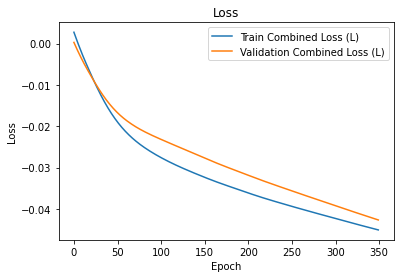

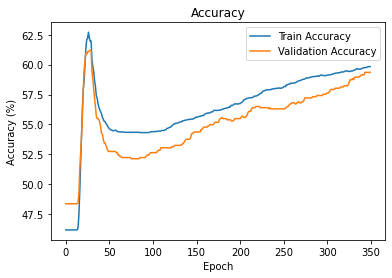

====== Test Results for Race: African American ======
TN: 346, FP: 25, FN: 288, TP: 92
False Positive Rate (FPR): 6.7385%


====== Test Results for Race: Caucasian ======
TN: 268, FP: 5, FN: 188, TP: 18
False Positive Rate (FPR): 1.8315%


====== Test Results ======
Testing Accuracy: 58.8618%
Difference in FPR between races: 4.9070%


In [ ]:
# ==== Test Results =====

# Selected model hyperparameters
input_dim = len(x_train.columns)
output_dim = 1
learningRate = 0.00001
alpha = 1
numEpochs = 350

# Train model and plot training and validation loss/accuracy
main_model, train_losses_L, train_accuracies, valid_losses_L, valid_accuracies, valid_fpr_diff = part2_train(input_dim, 
                    output_dim, learningRate, alpha, numEpochs, train_tensors, validation_tensors)
part2_plot(train_losses_L, train_accuracies, valid_losses_L, valid_accuracies)

# Get predictions
y_test_pred_c = torch.squeeze(torch.sigmoid(main_model(x_test_c_tensor))).round().detach().numpy()
y_test_pred_aa = torch.squeeze(torch.sigmoid(main_model(x_test_aa_tensor))).round().detach().numpy()

# Results for African American Race
aa_cm = confusion_matrix(y_test_aa_tensor.detach().numpy(), y_test_pred_aa)
aa_tn, aa_fp, aa_fn, aa_tp = aa_cm.ravel()
aa_fpr = 100.0*aa_fp/(aa_fp+aa_tn)
print("====== Test Results for Race: African American ======")
print("TN: %d, FP: %d, FN: %d, TP: %d" %(aa_tn, aa_fp, aa_fn, aa_tp))
print("False Positive Rate (FPR): %.4f%%" %(aa_fpr))
print("\n")

# Results for Caucasian Race
c_cm = confusion_matrix(y_test_c_tensor.detach().numpy(), y_test_pred_c)
c_tn, c_fp, c_fn, c_tp = c_cm.ravel()
c_fpr = 100.0*c_fp/(c_fp+c_tn)
print("====== Test Results for Race: Caucasian ======")
print("TN: %d, FP: %d, FN: %d, TP: %d" %(c_tn, c_fp, c_fn, c_tp))
print("False Positive Rate (FPR): %.4f%%" %(c_fpr))
print("\n")

# Test Results
print("====== Test Results ======")
print("Testing Accuracy: %.4f%%" %(100.0*(aa_tn + aa_tp + c_tn + c_tp)/(aa_tn + aa_fp + aa_fn + aa_tp + c_tn + c_fp + c_fn + c_tp)))
print("Difference in FPR between races: %.4f%%" %(abs(aa_fpr - c_fpr)))